In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
!ls "/content/drive/My Drive/dataset"

Dataset1.csv  Dataset2.csv


In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load dataset
dataset_path = "/content/drive/My Drive/dataset/Dataset1.csv"
df = pd.read_csv(dataset_path)
df.columns = df.columns.str.strip()  # Clean column names
df.columns = df.columns.astype(str)

# Convert 'Label' column to binary classification
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Features & Target
X = df.drop(columns=['Label'])
y = df['Label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train RandomForest to get feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)
rf_importances = rf_model.feature_importances_

# Train XGBoost to get feature importance
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_scaled, y)
xgb_importances = xgb_model.feature_importances_

# Select top 20 important features from both models
rf_top_features = np.argsort(rf_importances)[-20:]
xgb_top_features = np.argsort(xgb_importances)[-20:]
selected_features = list(set(X.columns[rf_top_features]) & set(X.columns[xgb_top_features]))

# Filter dataset with selected features
X_selected = df[selected_features]

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split balanced dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the base models for stacking
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8,
                          scale_pos_weight=len(y_train) / sum(y_train), random_state=42)),
]

# Final estimator in stacking is Logistic Regression
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Train and evaluate the stacked model
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   Actual Label Predicted Label
0     Malicious       Malicious
1        Normal          Normal
2        Normal          Normal
3     Malicious       Malicious
4        Normal          Normal
5        Normal          Normal
6        Normal          Normal
7        Normal          Normal
8        Normal          Normal
9     Malicious       Malicious
10       Normal          Normal
11       Normal          Normal
12       Normal          Normal
13       Normal          Normal
14       Normal       Malicious
15    Malicious       Malicious
16       Normal          Normal
17       Normal          Normal
18       Normal          Normal
19       Normal          Normal
20       Normal          Normal
21       Normal          Normal
22    Malicious       Malicious
23       Normal          Normal
24       Normal          Normal
25       Normal          Normal
26       Normal          Normal
27       Normal          Normal
28       Normal          Normal
29    Malicious       Malicious
30      

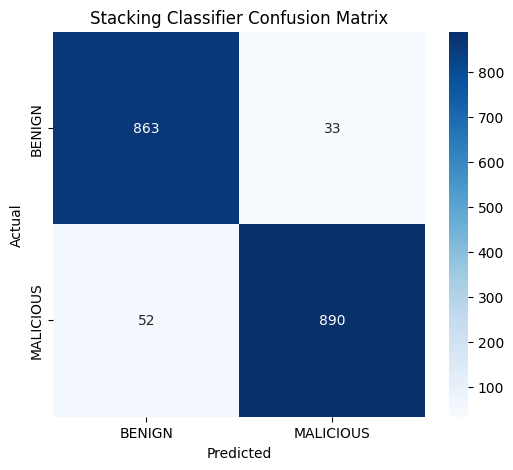

                   Top Features
0   Total Length of Bwd Packets
1         Fwd Packet Length Std
2                  Flow Bytes/s
3        Total Backward Packets
4        Bwd Packet Length Mean
5                Flow Packets/s
6        Fwd Packet Length Mean
7         Fwd Packet Length Max
8              Destination Port
9         Fwd Packet Length Min
10            Total Fwd Packets
11                Flow Duration
12        Bwd Packet Length Min
13  Total Length of Fwd Packets
14        Bwd Packet Length Max
15                Down/Up Ratio
16               URG Flag Count
17        Bwd Packet Length Std


In [71]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# Load dataset
dataset_path = "/content/drive/My Drive/dataset/Dataset2.csv"
data = pd.read_csv(dataset_path)

# Ensure all column names are strings
data.columns = df.columns.astype(str)
data.columns = data.columns.str.strip()  # Remove spaces from column names

# Extract the actual labels and convert them
if 'Label' in data.columns:
    actual_labels = data['Label'].apply(lambda x: "Normal" if x == "BENIGN" else "Malicious")
else:
    raise ValueError("Label column not found in dataset!")

# Drop the 'Label' column for prediction
Z = data.drop(columns=['Label'], errors='ignore')

# Ensure feature names match the trained model
if hasattr(stacking_model, "feature_names_in_"):
    missing_cols = set(stacking_model.feature_names_in_) - set(Z.columns)
    extra_cols = set(Z.columns) - set(stacking_model.feature_names_in_)

    # Add missing columns with default values (e.g., 0)
    for col in missing_cols:
        Z[col] = 0

    # Keep only the columns the model was trained on, in the correct order
    Z = Z[stacking_model.feature_names_in_]

# Make predictions
pred = stacking_model.predict(Z)

# Convert numerical predictions to readable labels
label_mapping = {0: "Normal", 1: "Malicious"}
pred_labels = np.array([label_mapping[p] for p in pred])

# Compare predictions with actual labels
comparison_df = pd.DataFrame({
    "Actual Label": actual_labels.values,
    "Predicted Label": pred_labels
})

# Calculate correctness percentage
correct_predictions = (comparison_df["Actual Label"] == comparison_df["Predicted Label"]).sum()
total_predictions = len(comparison_df)
accuracy = (correct_predictions / total_predictions) * 100

# Display first 100 comparisons and accuracy
print(comparison_df.head(50))  # Show first 100 results
print(f"\nPrediction Accuracy: {accuracy:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Classification Report for the test sample tested by model:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'MALICIOUS'], yticklabels=['BENIGN', 'MALICIOUS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Stacking Classifier Confusion Matrix')
plt.show()




features = pd.DataFrame(selected_features, columns=["Top Features"])
print(features)
